In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [3]:
from IPython.display import Image
from pandas import DataFrame 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname="/home/gezi/soft/simsunttc/msyh.ttf", size=12)  #size可不用指定

In [4]:
import gezi
from libgezi import utf82gbk, gbk2utf8

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
 
flags.DEFINE_string('vocab', '/home/gezi/new/temp/image-caption/lijiaoshou/tfrecord/seq-basic/vocab.txt', 'vocabulary file')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.keep100', '')
flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/', '')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.ct0', '')

#flags.DEFINE_string('vocab', '/home/gezi/new/temp/image-caption/keyword/tfrecord/seq-basic/vocab.txt', 'vocabulary file')
#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/keyword/model/rnn.lijiaoshou2/', '')

flags.DEFINE_string('seg_method_', 'basic', '')

flags.DEFINE_string('op_name', 'words_importance', 'default is cosine sim importance or encoder_words_importance for maxpooling importance')
#flags.DEFINE_string('op_name', 'encoder_words_importance', 'default is cosine sim importance or encoder_words_importance for maxpooling importance')

import gezi
import melt 
from deepiu.util import text2ids

import numpy as np

text2ids.init(FLAGS.vocab)

predictor = melt.Predictor(FLAGS.model_dir)

def predict(text, text2=None, topn=0):
  text = utf82gbk(text)
  timer = gezi.Timer()
  text_ids = text2ids.text2ids(text, FLAGS.seg_method_, feed_single=True)
  #print('text_ids', text_ids)
    
  if topn:
    #print(tf.get_default_graph().get_all_collection_keys())
    vocab = text2ids.vocab
    scores = predictor.inference('text_words_emb_score', feed_dict = {'rnn/main/text:0': [text_ids]})
    #print(scores)
    scores = scores[0]
    indexes = (-scores).argsort()[:topn]
    print(' '.join(['%s:%.6f'%(gbk2utf8(vocab.key(index)), scores[index]) for index in indexes]))
    return
    
  #print(tf.get_collection('debug_seqeuence'))
  #x  =  predictor.inference(['debug_seqeuence'], index=0,
  #                                  feed_dict= {
  #                                    'rnn/main/text:0': [text_ids]
  #                                    })

  #print(x)
  #return
    
    
  if text2 is not None:
    text2 = utf82gbk(text2)
    text2_ids = text2ids.text2ids(text2, FLAGS.seg_method_, feed_single=True)
    score = predictor.inference('text_emb_sim', 
                                    feed_dict= {
                                      'rnn/main/text:0': [text_ids],
                                      'rnn/main/text2:0': [text2_ids]
                                      #'rnn/main/text2:0':[gezi.pad([1], 50)]
                                      })
    print(score[0], len(score[0]))
    return score[0]

  #seq_len = 50	


  #print('words', words)
  argmax_encode = predictor.inference([FLAGS.op_name], 
                                    feed_dict= {
                                      'rnn/main/text:0': [text_ids]
                                      })
  #print('argmax_encode', argmax_encode[0])
  

  argmax_encode = argmax_encode[0][0]
  #argmax_encode = [max(x, 0) for x in argmax_encode]

  #print('----', len(argmax_encode))

  text_ids =  text2ids.text2ids(text, FLAGS.seg_method_, feed_single=True, append_start=True, append_end=True)
  words = text2ids.ids2words(text_ids)
    
  words = [gbk2utf8(x) for x in words]

  seq_len = 0
  for x in words:
  	if x != 0:
  		seq_len += 1
  	else:
  		break

  #print(text_ids)

   # visualize model
  import matplotlib.pyplot as plt
  #argmaxs = [np.sum((argmax_encode==k)) for k in range(seq_len)]
    
  argmaxs = argmax_encode[:seq_len]
  #print('argmaxs', argmaxs, np.sum(argmaxs), seq_len)
  x = range(len(argmaxs))
  total = sum([x for x in argmaxs if x > 0])
  y = [100.0*n/total for n in argmaxs]
  #print(words, y)
  print(gbk2utf8(text))
  
  #for word, score in zip(words, y):
  #  print(word, score)
  
  fig = plt.figure()
  
  #words = [x.decode('utf8') for x in words]
  #words = [i for i in range(len(words))]

  #plt.xticks(x, words, rotation=45)
  #plt.bar(x, y)
  #plt.ylabel('%')
  #plt.title('Visualisation of words importance')

  df = DataFrame({"%":y}, index=words) 
  ax = df.plot(kind = 'bar', rot = 90) 
  labels = [label.decode("utf-8") for label in df.index.values] 
  ax.set_xticklabels(labels, fontproperties=font) 
    
  #zhfont1 = matplotlib.font_manager.FontProperties(fname='/home/gezi/soft/simsunttc/msyh.ttf')
  #plt.xlabel('性别',fontproperties=zhfont1)
  #plt.ylabel('人数',fontproperties=zhfont1)
  #plt.xticks( (0,1),('男','女') ,fontproperties=zhfont1)
  #plt.bar(left=(0,1), height=(1,0.5), width=0.35)
  
  plt.title('Visualisation of words importance')
  #plt.title('句子词汇重要度')
  plt.show()

tensorflow_version: 1.2.0-rc0
ENCODE_UNK 1
restore from /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-120.0-153000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-120.0-153000


import graph ok /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-120.0-153000.meta
restore ok /home/gezi/new/temp/image-caption/lijiaoshou/model/rnn.w2v/model.ckpt-120.0-153000


In [6]:
def top_words(text, topn=100):
  return predict(text, topn=topn)

In [7]:
top_words('高铁')

铁:0.945993 高:0.550101 动车:0.509852 比重:0.473578 铜棒:0.469675 waki:0.464751 宾馆:0.454432 钨:0.452048 磁性:0.448323 钢轨:0.445951 产能:0.441840 bv:0.431866 烟壶:0.431526 加热:0.429816 13805194935:0.426494 卓众:0.425156 友泓:0.424295 天赐:0.424262 江浙:0.422069 停放:0.421273 报废:0.420824 盘扣:0.420791 回转:0.420766 派发:0.420713 想飞:0.420502 磁棒:0.419598 雷:0.419091 恒兴:0.417167 采煤:0.416481 旋:0.416138 亨通:0.415868 麦斯:0.415023 华迪克:0.414653 电视:0.414348 春雨:0.411321 博达:0.411016 架:0.410480 航宇:0.410259 三角:0.409690 huituo:0.408049 损耗:0.407964 四轮:0.407359 奥:0.407347 风驰:0.407118 住房:0.406939 搬厂:0.406777 锆:0.406030 合金:0.405646 瀚宇:0.405485 钯:0.405177 楼房:0.404843 拆装:0.404710 协力:0.404678 欧可:0.404465 加药:0.404339 火机:0.403484 精度:0.402751 盟:0.402649 背压:0.402434 敬老:0.402023 扫描:0.401897 电偶:0.401737 焊机:0.401001 dse:0.400897 碳钢:0.400376 箍筋:0.400344 一说:0.400309 静鑫通茂:0.400279 蒂:0.399358 组件:0.398964 文件:0.398934 灰钙粉:0.398692 运行:0.398542 16949:0.398143 沙子:0.397892 探照灯:0.397853 声光:0.397773 卡特:0.397526 露天:0.397352 艾希顿:0.397175 自动:0.397126 牧羊:0.397081 长宏

In [8]:
top_words('墨镜')

墨镜:1.000000 轻便:0.499280 pet:0.490737 开车:0.488484 音质:0.487174 手提:0.485184 泼水:0.482331 粉底:0.473882 减肥:0.473215 黄皮:0.472543 钛:0.467987 适配:0.466493 桶:0.464709 治脱发:0.464666 开水:0.464609 开关:0.464581 副:0.463039 古风:0.462870 皮尔兹:0.460646 皮靴:0.456763 送友:0.453226 薄膜:0.452399 车型:0.452198 垃圾:0.450848 档次:0.450440 卸妆:0.450151 摔:0.448669 茶叶:0.445735 运动:0.445372 药水:0.443692 瞳:0.442237 卧:0.441854 按摩:0.441502 机芯:0.441452 搭讪:0.441403 loho:0.441073 台球:0.439945 鹤:0.439816 组件:0.439658 衬托:0.439487 余款:0.438696 便器:0.438324 西裤:0.437799 代步:0.436634 这时候:0.436452 泡妞:0.436425 器:0.436057 狗粮:0.435249 电偶:0.435079 补水:0.434822 暴跌:0.434163 夏娃:0.433491 木瓜:0.433153 护肤:0.432094 追:0.431579 走路:0.431100 塑形:0.430946 太空:0.430158 龙海:0.429953 绞股蓝:0.429391 麦迪:0.428722 闭门:0.428491 烟熏:0.428398 绝望:0.427760 萝卜:0.427229 帽:0.427036 众一:0.426831 毫安:0.426650 吉他:0.426129 送亲:0.425973 哇:0.425814 衣柜:0.425799 将至:0.425567 ugg:0.425460 偏光:0.424985 bmw:0.424854 路灯:0.424137 恋爱:0.424092 箱:0.424069 放量:0.423897 刀锋:0.423611 穿出:0.423005 抖:0.422943 电控:0.421

In [9]:
predict('墨镜', '墨镜')

[ 1.00000024] 1


array([ 1.00000024], dtype=float32)

In [10]:
predict('墨镜', '鼻子')

[ 0.34577131] 1


array([ 0.34577131], dtype=float32)

In [11]:
top_words('美女')

美女:1.000000 裁缝:0.622213 直播:0.557821 主播:0.471387 热辣:0.450099 真人:0.446796 打牌:0.438292 开怀:0.434185 交友:0.430878 单身:0.430600 好听:0.429243 激战:0.424444 综艺:0.422659 追逐:0.420913 小丑:0.418877 婚恋:0.413749 萝:0.407207 当面:0.406741 妻子:0.405046 鬼怪:0.404639 求败:0.404545 赛鸽:0.402518 勇敢:0.398131 秀:0.397519 好转:0.395328 喵:0.395168 结识:0.394250 约会:0.393582 播:0.392349 娇羞:0.390948 唱歌:0.390761 女生:0.390393 校花:0.389165 占尽:0.388499 异性:0.388157 妹:0.388037 学姐:0.386412 闯过:0.386205 兴许:0.385203 抢注:0.384712 特效:0.384669 内向:0.384442 拆机:0.383841 1h:0.383698 睡着:0.383587 横着:0.383442 搭讪:0.381480 姐姐:0.380104 聊天:0.379884 相亲:0.379210 误事:0.377914 学长:0.377556 清纯:0.377121 出轨:0.376976 yy:0.376483 相投:0.376251 闲聊:0.375109 西甲:0.374469 地网:0.374467 枪战:0.373892 倍率:0.373660 收收:0.372796 无聊:0.372467 蹲:0.372236 万人:0.371140 录播:0.370536 随地:0.370484 假证:0.370074 急招:0.369874 富翁:0.369513 韩剧:0.369049 天兴:0.368461 买手:0.368299 道具:0.367431 爆棚:0.367397 强烈:0.367326 家财:0.365878 拿出:0.365339 遥远:0.364417 说服:0.364294 媒体:0.363785 同城:0.363747 sci:0.363682 么么:0.3634

iPhone隐藏功能：高铁也能在线选座了！


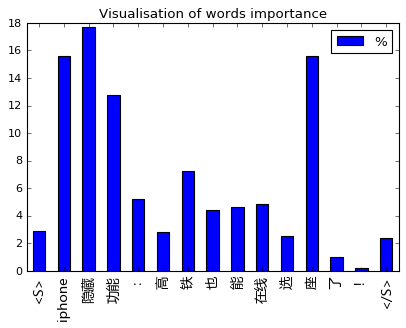

In [12]:
predict('iPhone隐藏功能：高铁也能在线选座了！')

In [13]:
predict('iPhone隐藏功能：高铁也能在线选座了！', 'iPhone')

[ 0.54775733] 1


array([ 0.54775733], dtype=float32)

In [14]:
predict('iPhone隐藏功能：高铁也能在线选座了！', '高铁')

[ 0.49517852] 1


array([ 0.49517852], dtype=float32)

In [15]:
predict('iPhone隐藏功能：高铁也能在线选座了！', '高铁选座')

[ 0.67305613] 1


array([ 0.67305613], dtype=float32)

往返飞旧金山?真是赚了,我一直在这里买!


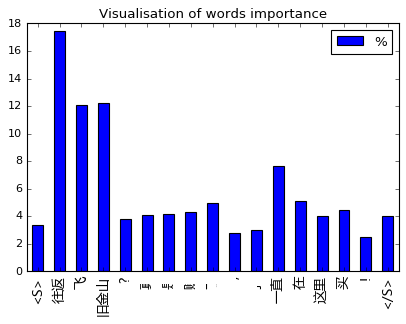

In [16]:
predict('往返飞旧金山?真是赚了,我一直在这里买!')

我的家乡惠州越来越热，选一款喜欢的墨镜很重要


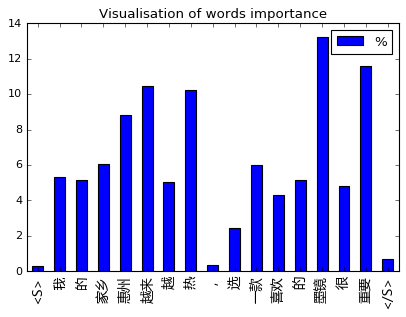

In [17]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要')

In [18]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要', '我的家乡惠州越来越热')

[ 0.82114851] 1


array([ 0.82114851], dtype=float32)

In [19]:
predict('我的家乡惠州越来越热，选一款喜欢的墨镜很重要', '选一款喜欢的墨镜很重要')

[ 0.8132056] 1


array([ 0.8132056], dtype=float32)

In [20]:
predict('选一款喜欢的墨镜很重要,我的家乡惠州越来越热', '我的家乡惠州越来越热')

[ 0.80344129] 1


array([ 0.80344129], dtype=float32)

In [21]:
predict('选一款喜欢的墨镜很重要,我的家乡惠州越来越热', '选一款喜欢的墨镜很重要')

[ 0.8373214] 1


array([ 0.8373214], dtype=float32)

我的家乡越来越热，选一款喜欢的墨镜很重要


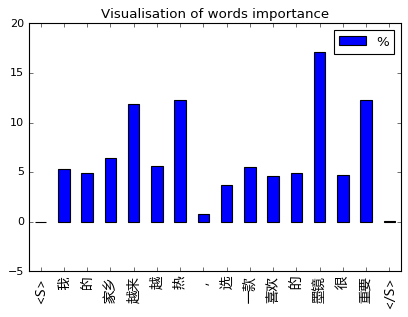

In [22]:
predict('我的家乡越来越热，选一款喜欢的墨镜很重要')

选一款喜欢的墨镜很重要，我的家乡越来越热


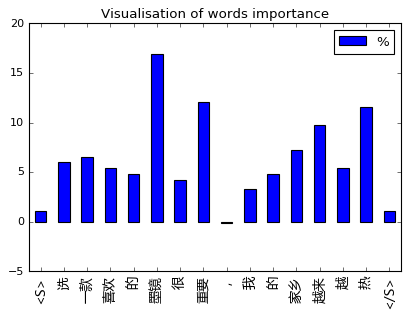

In [23]:
predict('选一款喜欢的墨镜很重要，我的家乡越来越热')

选一款喜欢的墨镜很重要


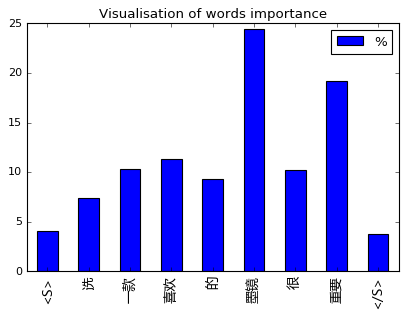

In [24]:
predict('选一款喜欢的墨镜很重要')

不要住酒店，这里的民宿好


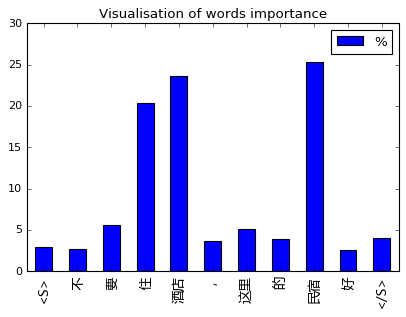

不要住民宿，这里的酒店好


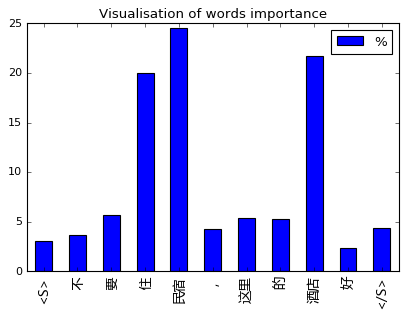

In [25]:
predict('不要住酒店，这里的民宿好')
predict('不要住民宿，这里的酒店好')

In [26]:
top_words('酒店')

酒店:1.000000 布草:0.613788 格雷斯:0.613194 宾馆:0.579707 情侣:0.578179 地毯:0.547857 布置:0.539527 喜来登:0.536201 民宿:0.532723 水疗:0.529548 面馆:0.529255 会场:0.524310 七彩堂:0.524207 会所:0.523082 评价:0.518958 厨房:0.517791 开张:0.511059 菜:0.507783 场地:0.507169 办公:0.505027 旅馆:0.502028 小蓝:0.501526 浪漫:0.501352 餐厅:0.501261 婚庆:0.501049 1700:0.500407 五环:0.498969 客房:0.498137 用品:0.497845 四合院:0.497738 携程:0.496751 科勒:0.496156 ktv:0.494928 海底:0.494619 桑拿:0.494267 食堂:0.493752 婚礼:0.493703 饭店:0.491991 装修:0.489592 泳池:0.489306 红专:0.488647 间:0.485599 寄卖:0.485333 自营:0.483526 嘉宝:0.483395 度假:0.482754 马桶:0.482453 enjoy:0.481278 游泳:0.479208 古兰:0.477612 池:0.476971 同里:0.476791 住:0.474921 月子:0.474068 窗帘:0.472753 三大:0.472572 桌椅:0.472040 极小:0.471950 玩偶:0.471253 迪斯尼:0.470984 大阪:0.470810 春游:0.470141 披萨:0.470059 摊位:0.469995 会议:0.469740 酒吧:0.469668 保洁:0.468631 院:0.468443 炊具:0.468417 广田:0.467437 火锅:0.467398 婚宴:0.466915 院子:0.466891 游艇:0.466626 公寓:0.464728 体育:0.463476 金翔:0.463077 游乐:0.462226 阳春:0.461931 排烟:0.460673 蓝调:0.460643 醒悟:0.460626 大观:0.46018

In [27]:
top_words('新加坡')

新加坡:1.000000 service:0.543712 旧金山:0.484410 lan:0.477443 来自:0.476411 新山:0.470361 香港:0.469045 富力:0.468112 121:0.464992 左邻:0.464561 海景:0.461038 蒂:0.460037 ka:0.456877 旅游:0.456379 移民:0.449464 华侨:0.448293 那里:0.442949 迪拜:0.441572 移居:0.438635 107:0.435067 欧洲:0.434726 正序:0.434474 73:0.433502 置业:0.433184 南沙:0.432231 澳洲:0.431447 仙草:0.430095 首尔:0.426662 穷游:0.424952 美国:0.424326 7900:0.424043 联展:0.423912 长岛:0.422848 西昌:0.422741 遨游:0.422197 1900:0.421557 三期:0.421550 彩票:0.420646 l1:0.419651 压铸:0.418563 社:0.417872 国航:0.417846 马来西亚:0.416726 清迈:0.415843 汇福:0.414940 57:0.414320 多次:0.413739 航空:0.413650 湄公:0.413363 上城:0.413174 海底:0.412786 悦榕:0.412542 湖边:0.411796 梅州:0.411682 enomatic:0.411506 富鑫:0.408633 天宸:0.406612 7200:0.406566 五国:0.405852 嘉汇:0.405766 各国:0.405377 蜜柚:0.404963 大阪:0.404810 p50:0.403581 自贸区:0.403263 专列:0.402858 买票:0.402256 蚌埠:0.402108 雅诗阁:0.401700 芙蓉:0.401630 c1:0.401607 〔:0.400370 金科:0.399888 滨海:0.399039 路线:0.398430 丽景湾:0.398004 欧元:0.397413 湾:0.397290 领秀:0.395758 看房:0.395096 食材:0.395077 打猎:0

In [28]:
top_words('民宿')

民宿:1.000000 旅馆:0.568552 海底:0.550272 酒店:0.532723 房产:0.511364 大鹏:0.508132 水杉:0.506384 泳池:0.501229 承建:0.496230 宾馆:0.494813 歇:0.494600 窗帘:0.494166 涿州:0.493521 楼盘:0.490965 景观:0.490811 游乐:0.490597 住:0.490062 订房:0.489917 客栈:0.489520 风景:0.485394 公寓:0.484208 峨眉:0.481275 乐园:0.480027 正序:0.478793 别墅:0.478224 独栋:0.476891 渲染:0.473988 精装:0.473756 城堡:0.472885 现实:0.472666 宝安:0.470983 看房:0.470579 平谷:0.470175 格雷斯:0.469249 装潢:0.469157 墅:0.468959 康体:0.466920 豪宅:0.464368 金翔:0.462886 九寨沟:0.462786 毛坯:0.462420 星际:0.461550 竟能:0.461202 五环:0.460305 和风:0.460176 通风:0.460125 堵车:0.459175 和美:0.458095 度假:0.458093 尾盘:0.458093 装出:0.457855 白鹭:0.456493 繁殖:0.456453 江华:0.455830 墙纸:0.454108 新都:0.453068 梅州:0.452952 租房:0.452372 济州:0.452349 旅游:0.451660 龙亭:0.451006 清远:0.450791 汗蒸:0.450572 病人:0.449884 小狗:0.449711 雨棚:0.449689 游玩:0.449561 院子:0.449262 绿地:0.449225 跳:0.447794 床:0.447778 装修:0.447292 冰雪:0.446944 翻新:0.446503 养老:0.446083 巨龙:0.445979 旅行:0.445697 宴:0.445461 套房:0.445440 房:0.444801 双飞:0.444374 风情:0.444359 水电:0.444088 水道:0.4438

In [29]:
top_words('酒店')

酒店:1.000000 布草:0.613788 格雷斯:0.613194 宾馆:0.579707 情侣:0.578179 地毯:0.547857 布置:0.539527 喜来登:0.536201 民宿:0.532723 水疗:0.529548 面馆:0.529255 会场:0.524310 七彩堂:0.524207 会所:0.523082 评价:0.518958 厨房:0.517791 开张:0.511059 菜:0.507783 场地:0.507169 办公:0.505027 旅馆:0.502028 小蓝:0.501526 浪漫:0.501352 餐厅:0.501261 婚庆:0.501049 1700:0.500407 五环:0.498969 客房:0.498137 用品:0.497845 四合院:0.497738 携程:0.496751 科勒:0.496156 ktv:0.494928 海底:0.494619 桑拿:0.494267 食堂:0.493752 婚礼:0.493703 饭店:0.491991 装修:0.489592 泳池:0.489306 红专:0.488647 间:0.485599 寄卖:0.485333 自营:0.483526 嘉宝:0.483395 度假:0.482754 马桶:0.482453 enjoy:0.481278 游泳:0.479208 古兰:0.477612 池:0.476971 同里:0.476791 住:0.474921 月子:0.474068 窗帘:0.472753 三大:0.472572 桌椅:0.472040 极小:0.471950 玩偶:0.471253 迪斯尼:0.470984 大阪:0.470810 春游:0.470141 披萨:0.470059 摊位:0.469995 会议:0.469740 酒吧:0.469668 保洁:0.468631 院:0.468443 炊具:0.468417 广田:0.467437 火锅:0.467398 婚宴:0.466915 院子:0.466891 游艇:0.466626 公寓:0.464728 体育:0.463476 金翔:0.463077 游乐:0.462226 阳春:0.461931 排烟:0.460673 蓝调:0.460643 醒悟:0.460626 大观:0.46018

In [30]:
top_words('我的家乡惠州越来越热,选一款喜欢的墨镜很重要')

墨镜:0.594869 惠州:0.523955 波形:0.493985 护肤:0.485869 迷人:0.481026 人防:0.477266 卷扬机:0.474410 涂塑:0.473361 康达:0.472695 台球:0.468836 喷嘴:0.463182 落水:0.463132 织带:0.462792 膜:0.462788 电控:0.462767 薄膜:0.461503 组件:0.461263 越来:0.459776 收银机:0.459301 优品:0.458980 古风:0.458758 节奏:0.458689 宾馆:0.458433 床垫:0.457517 磁棒:0.457037 pet:0.456815 导电:0.456762 金蝶:0.456302 烘箱:0.455361 管材:0.454687 给水:0.454455 the:0.454403 pe管:0.454059 晾:0.453780 专科:0.453689 围网:0.453669 车载:0.453010 首先:0.452734 粉底:0.452155 围栏:0.451834 结实:0.451766 送友:0.451719 入手:0.450629 美籍:0.450201 冷却:0.450162 电偶:0.449655 木盒:0.449593 吉他:0.449583 滑梯:0.449298 唔:0.448689 街机:0.448112 热:0.447624 冷弯:0.447398 胶带:0.447169 七星:0.447085 香水:0.447037 酚醛:0.446881 开水:0.446792 通风:0.446771 药水:0.446541 衣柜:0.446285 尽情:0.445987 零食:0.445947 镀:0.445413 写真:0.445205 xy:0.444347 grg:0.444336 首饰:0.444250 卷帘:0.443158 储罐:0.442895 路灯:0.442686 写字:0.441994 土工:0.441421 压机:0.441293 车棚:0.441251 衣架:0.440949 科勒:0.439665 国航:0.439511 红木:0.439220 型钢:0.439201 充气:0.438793 麻将:0.438661 卧:0.438646 邦泰:0

In [31]:
top_words('选一款喜欢的墨镜很重要')

墨镜:0.706802 重要:0.522246 古风:0.485229 上身:0.476290 衣柜:0.472143 将至:0.469145 尤其:0.468642 ugg:0.464800 茶叶:0.464355 帅气:0.460231 黄皮:0.459523 夹克:0.458867 送友:0.452150 一款:0.451865 斗拱:0.451286 皮尔兹:0.450889 绒裤:0.450587 奶瓶:0.450508 松软:0.450092 音质:0.448375 运动:0.448210 鞋:0.447750 手提:0.446689 吉他:0.446688 498:0.445651 入手:0.445341 西裤:0.444459 药水:0.443642 淡:0.442573 皮靴:0.442161 轻便:0.441868 红木:0.441223 台球:0.440354 绵羊:0.440223 衣服:0.439856 loho:0.438679 文人:0.438563 粉底:0.438256 档次:0.437543 麻将:0.436291 乐坛:0.435884 项链:0.434745 1212:0.434553 落水:0.434388 皮鞋:0.433979 好学:0.433525 feel:0.433182 免考:0.432747 科凡:0.432622 送亲:0.432328 腕表:0.431138 组件:0.431120 好运:0.430552 护肤:0.430480 牙齿:0.429268 地气:0.429014 清爽:0.428628 型男:0.427893 打球:0.427520 296:0.427514 西服:0.426743 喜欢:0.426678 首饰:0.426663 副:0.426450 abs:0.426390 潮:0.426205 蜜蜡:0.425168 pet:0.424598 穿出:0.424172 这时候:0.423723 桌:0.423518 涂塑:0.423273 胶带:0.423159 祛痘:0.422262 表带:0.422083 皮包:0.421717 减肥:0.421673 开水:0.421605 管材:0.421059 补水:0.420742 千百度:0.420410 佩戴:0.420342 眼:0.420

In [32]:
top_words('nike')

nike:1.000000 耐克:0.643131 dw:0.510450 平行:0.496939 清障:0.491479 正品:0.485632 club:0.484536 金杯:0.484193 用车:0.480566 跑步:0.477097 耐卡:0.474588 游艇:0.472992 旅游:0.470140 威固:0.468138 绅宝:0.465971 徕卡:0.461216 gox:0.459735 一千多:0.459426 专柜:0.457732 健步:0.457139 air:0.456734 华人:0.456381 王开:0.455402 com:0.453169 五十铃:0.452883 房车:0.450334 色差:0.449814 龙粤:0.449282 旅行:0.448640 风神:0.447722 奔驰:0.446924 包车:0.446851 机芯:0.446766 海狮:0.446119 包天:0.446051 租车:0.445437 余氯:0.444345 大巴:0.443633 专卖:0.443010 专修:0.442655 斑马:0.442208 benro:0.441602 toyota:0.441574 gia:0.441563 上汽:0.441375 游览:0.441281 围网:0.441174 奥迪:0.438132 g10:0.437980 安通:0.437129 v80:0.436991 出海:0.436809 海康威视:0.436499 吴氏:0.436325 免税:0.436254 东丽:0.435882 美合:0.435845 4s店:0.435324 折叠:0.434664 母线:0.433499 童车:0.433468 巢:0.433268 潘多拉:0.433138 贴膜:0.432010 停车:0.432003 燎原:0.431753 仁恒:0.431426 中汽:0.431144 振雄:0.431002 缤:0.430858 正方:0.430484 party:0.430169 my:0.429921 車:0.429795 汽配:0.429675 斯宾特:0.429633 婚庆:0.429622 零担:0.429504 台球:0.429284 打球:0.428959 藝:0.428858 沃森:0.

In [33]:
top_words('耐克')

耐克:1.000000 nike:0.643131 阿迪:0.557826 专柜:0.537582 名表:0.518632 婚庆:0.498681 邓禄普:0.496573 三双:0.493221 清障:0.481177 169:0.476118 圣诞:0.475442 婚宴:0.475103 专营:0.474205 零食:0.473547 三叶:0.472898 悠哉:0.472814 送友:0.471840 正品:0.469454 ugg:0.467273 鞋:0.465333 特产:0.460701 送亲:0.459747 车棚:0.456583 会议:0.456481 双肩:0.455582 奔驰:0.454060 奢侈:0.451785 策划:0.450423 金粤:0.447193 婚礼:0.446819 gox:0.446513 专卖:0.446442 百多:0.444194 旅游:0.443915 鞋子:0.443317 到货:0.442419 296:0.442209 手表:0.442146 碧桃:0.441842 房车:0.441149 凉亭:0.440251 膜:0.440217 阅:0.438998 水池:0.438697 金面:0.437956 房贷:0.437581 旅行:0.436923 白菜:0.434815 年货:0.434458 围栏:0.433548 呼叫:0.432672 玉柴:0.432554 寄养:0.432516 停车:0.431913 骏马:0.431851 大牌:0.431264 dw:0.431041 买到:0.430849 跑鞋:0.430520 金杯:0.430113 围网:0.429554 再买:0.428742 鱼苗:0.428741 摊位:0.428649 流量:0.428603 美合:0.427915 健步:0.427748 场馆:0.427097 临平:0.426611 久业:0.426574 音箱:0.426561 较好:0.425892 抓起:0.424522 用车:0.424193 字画:0.423874 外景:0.423595 候车:0.422721 首饰:0.422415 威尔:0.422333 盲目:0.422187 缠绕:0.422084 理赔:0.421203 包车:0.421144 

In [34]:
top_words('重演')

重演:1.000000 色调:0.838863 得体:0.622937 斜纹:0.612755 棕色:0.603848 时尚:0.590921 抽象:0.590583 金丝绒:0.588546 大波:0.584924 gxg:0.577228 裙裤:0.575107 高领:0.567759 款式:0.565997 五中:0.565735 每季:0.562242 翻领:0.557287 提花:0.557272 新款:0.555609 柄:0.548293 高傲:0.546703 毛线:0.545750 小方:0.544006 三味:0.543355 三人:0.542101 礼帽:0.540663 通勤:0.540639 jolin:0.539677 绸:0.535599 缝制:0.534274 梭:0.531878 呢子:0.531798 碎花:0.529269 shopping:0.528858 两会:0.528220 soiree:0.526607 aj:0.526197 极简:0.525731 甜美:0.525697 定做:0.525289 媤:0.525249 水域:0.521801 金典:0.520767 清货:0.520647 魅力:0.520393 开叉:0.520139 感性:0.520043 绒裤:0.516268 轻盈:0.516011 媞:0.515477 考究:0.515142 裁衣:0.514211 颊:0.513582 福泰欣:0.513562 穿出:0.513335 圆头:0.513007 两面:0.512847 搅:0.512224 面料:0.512168 格子:0.511776 春夏:0.508946 镂空:0.508721 冰丝:0.508300 旺销:0.507275 奖牌:0.505771 出彩:0.505243 尽显:0.504238 系带:0.503680 利落:0.503203 唇妆:0.503166 条纹:0.501782 羚羊:0.501747 原单:0.501479 越岭:0.499107 穿:0.498793 修剪:0.498675 身穿:0.498406 橱:0.498333 wowo:0.498213 男装:0.497029 折扣:0.496474 腕:0.496312 遵:0.496183 避暑:0.4950

In [35]:
top_words('电视')

电视:1.000000 液晶:0.617417 kuset:0.610806 彩电:0.558862 创奇:0.527376 广播:0.519454 拆机:0.517884 拼接:0.507098 tvc:0.499597 待命:0.498045 高金:0.495613 视:0.493889 天线:0.492026 did:0.491373 步频:0.490872 寰:0.488700 富通:0.486080 丹佛:0.482873 屏:0.481776 影视:0.481222 转椅:0.480975 昮:0.478885 可视:0.478026 显示:0.477035 储值:0.476546 斯斐德:0.473863 赛鸽:0.473191 tv:0.470733 兆信:0.469882 艺考:0.468036 wdp:0.466608 投影:0.464225 华强北:0.463288 广告:0.462706 if:0.458824 dtsx:0.458412 土石方:0.456487 神威:0.456453 博雅:0.455523 蒙古:0.455460 灏:0.454898 m1:0.453889 触手:0.452751 形势:0.450717 滴胶:0.449231 维修:0.447145 天笔:0.446921 lg:0.446415 江民:0.445922 中星:0.445562 佳信:0.445273 u盘:0.445087 德兰:0.444199 珞珈:0.444079 海翔:0.443744 led:0.443696 oracle:0.442169 蒙娜丽莎:0.441195 电信:0.440821 ehs:0.439820 剧:0.439394 视听:0.438884 吊绳:0.438852 根宝:0.438567 hdr:0.437195 深化:0.436783 菲尼特:0.436536 媒体:0.435802 奥委会:0.435390 喷泉:0.434819 旗云:0.433860 尊爵:0.433693 婚照:0.432602 racol:0.432312 恒美:0.431765 布展:0.431608 雾化:0.431089 英墨:0.430678 泵厂:0.429963 地址:0.429823 好再来:0.428794 模糊:0.428

In [36]:
top_words('墨镜')

墨镜:1.000000 轻便:0.499280 pet:0.490737 开车:0.488484 音质:0.487174 手提:0.485184 泼水:0.482331 粉底:0.473882 减肥:0.473215 黄皮:0.472543 钛:0.467987 适配:0.466493 桶:0.464709 治脱发:0.464666 开水:0.464609 开关:0.464581 副:0.463039 古风:0.462870 皮尔兹:0.460646 皮靴:0.456763 送友:0.453226 薄膜:0.452399 车型:0.452198 垃圾:0.450848 档次:0.450440 卸妆:0.450151 摔:0.448669 茶叶:0.445735 运动:0.445372 药水:0.443692 瞳:0.442237 卧:0.441854 按摩:0.441502 机芯:0.441452 搭讪:0.441403 loho:0.441073 台球:0.439945 鹤:0.439816 组件:0.439658 衬托:0.439487 余款:0.438696 便器:0.438324 西裤:0.437799 代步:0.436634 这时候:0.436452 泡妞:0.436425 器:0.436057 狗粮:0.435249 电偶:0.435079 补水:0.434822 暴跌:0.434163 夏娃:0.433491 木瓜:0.433153 护肤:0.432094 追:0.431579 走路:0.431100 塑形:0.430946 太空:0.430158 龙海:0.429953 绞股蓝:0.429391 麦迪:0.428722 闭门:0.428491 烟熏:0.428398 绝望:0.427760 萝卜:0.427229 帽:0.427036 众一:0.426831 毫安:0.426650 吉他:0.426129 送亲:0.425973 哇:0.425814 衣柜:0.425799 将至:0.425567 ugg:0.425460 偏光:0.424985 bmw:0.424854 路灯:0.424137 恋爱:0.424092 箱:0.424069 放量:0.423897 刀锋:0.423611 穿出:0.423005 抖:0.422943 电控:0.421